# 주식 예측(Naver)

1. 시계열 데이터 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = '/content/drive/MyDrive/AIFFEL/EXP/naver.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2018-04-30    143200.0
2018-05-02    147600.0
2018-05-03    145400.0
2018-05-04    143400.0
2018-05-08    146200.0
Name: Close, dtype: float64

2. 각종 전처리 - 결측치 처리, 로그 변환

In [3]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [4]:
ts_log = np.log1p(ts)

3. 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky_Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


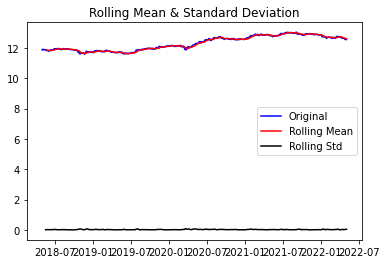

Results of Dickey-Fuller Test:
Test Statistic                  -0.865783
p-value                          0.799032
#Lags Used                       1.000000
Number of Observations Used    985.000000
Critical Value (1%)             -3.437006
Critical Value (5%)             -2.864479
Critical Value (10%)            -2.568335
dtype: float64


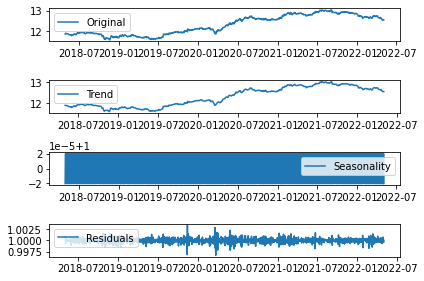

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose

ts_log.interpolate(inplace = True)
decomposition = seasonal_decompose(ts_log, model='multiplicative', freq =2) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [7]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.432158e+01
p-value                        1.138903e-26
#Lags Used                     1.600000e+01
Number of Observations Used    9.680000e+02
Critical Value (1%)           -3.437123e+00
Critical Value (5%)           -2.864530e+00
Critical Value (10%)          -2.568362e+00
dtype: float64


4. 학습 Test Data Set 분리

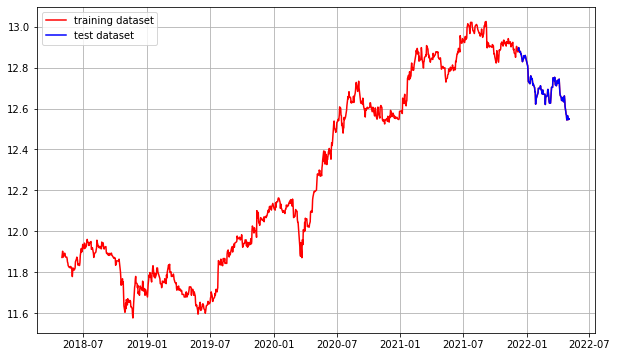

In [8]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
# train - 90 %, test - 10 %
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

5. 적정 ARIMA 모수 찾기

ARIMA(Autoregressive Integrated Moving Average) 모델

AR(자기회귀, Autoregressive)
AR은 일반적인 시계열에서 Trend와 Seasonality를 제거한 Residual에 해당하는 부분을 모델링
주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점에 해당
I (차분누적, Integration)
I는 일반적인 시계열에서 Seasonality에 해당하는 부분을 모델링
이전 데이터와 d차 차분의 누적(integration) 합이라고 보는 모델
MA(이동평균, Moving Average)

MA는 일반적인 시계열에서 Trend에 해당하는 부분을 모델링
주식값은 항상 최근의 증감 패턴이 지속될 것이라고 예측하는 관점
ARIMA의 파라미터 p,d,q

자기회귀 모형(AR)의 시차를 의미하는 p, 차분(diffdrence) 횟수를 의미하는 d, 이동평균 모형(MA)의 시차를 의미하는 q
p + q < 2, p * q = 0 인 값들을 사용
ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)을 통해 결정가능함

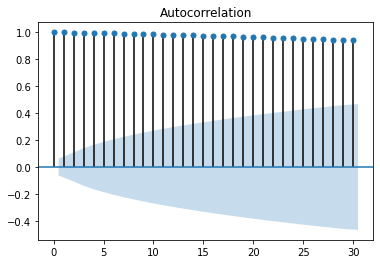

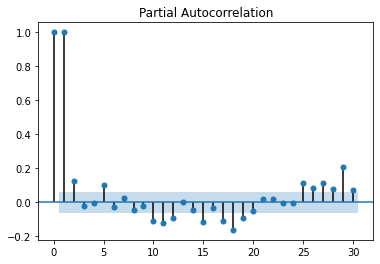

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

정상성 데이터를 만들기 위해 1차 차분하고 2차 차분까지 하였다.

Results of Dickey-Fuller Test:
Test Statistic                 -32.998335
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    985.000000
Critical Value (1%)             -3.437006
Critical Value (5%)             -2.864479
Critical Value (10%)            -2.568335
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.428964e+01
p-value                        1.282151e-26
#Lags Used                     1.600000e+01
Number of Observations Used    9.680000e+02
Critical Value (1%)           -3.437123e+00
Critical Value (5%)           -2.864530e+00
Critical Value (10%)          -2.568362e+00
dtype: float64


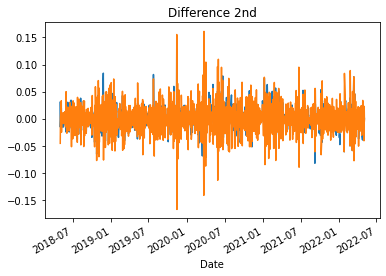

In [10]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

6. ARIMA 모델 훈련과 테스트

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(4, 0, 1))
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  888
Model:                     ARMA(4, 1)   Log Likelihood                2135.750
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 05 May 2022   AIC                          -4257.501
Time:                        07:19:56   BIC                          -4223.978
Sample:                             0   HQIC                         -4244.686
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.3116      0.316     38.969      0.000      11.692      12.931
ar.L1.Close     1.9148      0.000   1.79e+04      0.000       1.915       1.915
ar.L2.Close    -0.8400      0.000  -3771.405    

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [ ]:
# # Forecast : 결과가 fc에 담깁니다. 
# fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
# fc = np.array(fc, dtype = object)
# # Make as pandas series
# fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# # Plot
# plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data, label='training')
# plt.plot(test_data, c='b', label='actual price')
# plt.plot(fc_series, c='r',label='predicted price')
# plt.legend()
# plt.show()

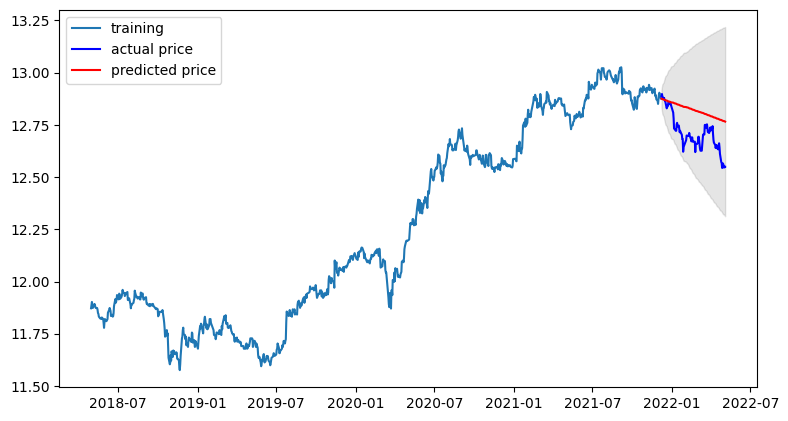

In [14]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  1822522276.7659247
MAE:  37695.44241002362
RMSE:  42691.00932006556
MAPE: 11.89%
